<a href="https://colab.research.google.com/github/pankaj90382/TSAI/blob/master/S6/EVA04S06_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#!pip install torchsummary
from torchsummary import summary
import pandas as pd
import numpy as np

In [0]:
# To store the torch files
!mkdir -p "content/EVA4"

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
class MNISTDigitBuilder(nn.Module):
    def __init__(self, dropout=0.1):
        super(MNISTDigitBuilder, self).__init__()
        self.dropout_val = dropout
        self.bias = False
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, stride=1,bias=self.bias),            
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(8, 8, 3, padding=1, stride=1,bias=self.bias),            
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # nn.Conv2d(8, 8, 3, padding=1, bias=self.bias),            
            # nn.BatchNorm2d(8),
            # nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1,stride=1, bias=self.bias),            
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(8, 16, 3, padding=1, bias=self.bias),            
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val),
            # nn.Conv2d(16, 16, 3, padding=1, bias=self.bias),            
            # nn.BatchNorm2d(16),
            # nn.ReLU(),
            #nn.MaxPool2d(2, 2),
            #nn.Dropout(self.dropout_val)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3,bias=self.bias),            
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(16, 16, 3,bias=self.bias),            
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val)
        )
        
        self.gap_linear = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(16, 10, 1, bias=self.bias)
        )
                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        #x = x.view(x.size(0), -1)
        x = self.gap_linear(x)
        x = x.view(-1, 10)
        x = F.log_softmax(x, dim=1)
        return x

"""
    Creates the model object on the specified device
"""
def model_builder(model_class=None, weights_path=None, local_device=torch.device("cpu")):
    if (model_class == None):
        print("Please provide the model object to be used")
        return
    local_model = model_class()#.to(local_device)
    try:
        if (weights_path != None):
            checkpoint = torch.load(weights_path)
            local_model.load_state_dict(checkpoint['model_state_dict'])
                #torch.load(weights_path, map_location=local_device))           
    except:
        print("Some execption occured during loading the model")
    return local_model.to(local_device)


In [0]:
import random
import os
import numpy as np
import pandas as pd

def generate_model_save_path(base="/content/EVA4/",mod_string=None):
    file_name = "model-"+mod_string+".h5"
    return os.path.join(base,file_name)

In [5]:
model = MNISTDigitBuilder(dropout=0.1).to(device)
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
       BatchNorm2d-6            [-1, 8, 28, 28]              16
              ReLU-7            [-1, 8, 28, 28]               0
         MaxPool2d-8            [-1, 8, 14, 14]               0
           Dropout-9            [-1, 8, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             576
      BatchNorm2d-11            [-1, 8, 14, 14]              16
             ReLU-12            [-1, 8, 14, 14]               0
          Dropout-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 16,

In [0]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
from tqdm import tqdm
def train(args, model, device, train_loader, optimizer, epoch_number,l1_loss=False, l1_beta = 0):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_accuracy += pred.eq(target.view_as(pred)).sum().item()
        loss = F.nll_loss(output, target)
        if l1_loss == True:
            l1_crit = nn.L1Loss(size_average=False)
            reg_loss = 0
            for param in model.parameters():
                target = torch.zeros_like(param)    
                reg_loss += l1_crit(param, target)
            loss += (l1_beta * reg_loss)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = (100. * train_accuracy) / len(train_loader.dataset)
    return train_accuracy, train_loss

def test(args, model, device, test_loader, epoch_number):
    model.eval()
    test_loss = 0
    correct = 0
    example_images = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = (100. * correct) / len(test_loader.dataset)
    return test_accuracy, test_loss

# Base Model with 40 Epochs
# Model-Path: /content/EVA4/model-baseline.h5

In [17]:
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR
import os
hyperparameter_defaults = dict(
    run_nam
    dropout = 0.1,
    batch_size = 82,
    test_batch_size=34,
    lr = 0.025, 
    momentum = 0.9,
    no_cuda = False,
    seed = 1,
    epochs = 40,
    bias = False,
    sched_lr_gamma = 0.5,
    sched_lr_step= 2,
    start_lr = 7,
    weight_decay=0
    )

Baseline_Model_Metrics={
    'Train Accuracy': [], 
    'Train Loss': [], 
    'Test Accuracy':[], 
    'Test Loss': [],
    'Learning Rate': [], 
    'Decay Learning Rate': []
}

config = hyperparameter_defaults
model_path = generate_model_save_path(mod_string="baseline")
print("Model will be saved to:", model_path)

def main():
    use_cuda = not config['no_cuda'] and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
  
    torch.manual_seed(config['seed']) # pytorch random seed
    torch.backends.cudnn.deterministic = True

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=train_transforms),
        batch_size=config['batch_size'], shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=test_transforms),
        batch_size=config['batch_size'], shuffle=True, **kwargs)
    
    model = MNISTDigitBuilder(dropout=config['dropout']).to(device)
    optimizer = optim.SGD(model.parameters(), lr=config['lr'],
                          momentum=config['momentum'], weight_decay=config['weight_decay'])
    
    scheduler = StepLR(optimizer, step_size=config['sched_lr_step'], gamma=config['sched_lr_gamma'])

    for epoch in range(1, config['epochs'] + 1):
        epoch_train_acc,epoch_train_loss = train(config, model, device, train_loader, optimizer, epoch)        
        epoch_test_acc,epoch_test_loss = test(config, model, device, test_loader,epoch)

        print('\nEpoch: {:.0f} Train set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(epoch, epoch_train_loss, epoch_train_acc))
        print('Epoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(epoch, epoch_test_loss, epoch_test_acc))
        myoptim = optimizer.state_dict()['param_groups'][0]

        print('Epoch: {:.0f} Optimizer values: LastLR:{:.10f}, Momentum: {:.10f}, Weight Decay: {:.10f}'.format(
        epoch, scheduler.get_last_lr()[0],myoptim['momentum'],myoptim['weight_decay']))
       
        Baseline_Model_Metrics['Train Accuracy'].append(epoch_train_acc)
        Baseline_Model_Metrics['Train Loss'].append(epoch_train_loss)
        Baseline_Model_Metrics['Test Accuracy'].append(epoch_test_acc)
        Baseline_Model_Metrics['Test Loss'].append(epoch_test_loss)
        Baseline_Model_Metrics['Learning Rate'].append(config['lr'])
        Baseline_Model_Metrics['Decay Learning Rate'].append(scheduler.get_lr()) 

        if (epoch > config['start_lr']):
            scheduler.step()

    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, model_path)

if __name__ == '__main__':
    main()

Model will be saved to: /content/EVA4/model-690613fdea.h5



Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


  0%|          | 0/732 [00:00<?, ?it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 1 Train set: Average loss: 0.0038, Accuracy: 90.443%
Epoch: 1 Test set: Average loss: 0.0594, Accuracy: 98.080%
Epoch: 1 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.0015, Accuracy: 96.290%
Epoch: 2 Test set: Average loss: 0.0460, Accuracy: 98.530%
Epoch: 2 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.0012, Accuracy: 96.932%
Epoch: 3 Test set: Average loss: 0.0364, Accuracy: 98.930%
Epoch: 3 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.0011, Accuracy: 97.507%
Epoch: 4 Test set: Average loss: 0.0342, Accuracy: 98.940%
Epoch: 4 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 0.0010, Accuracy: 97.465%
Epoch: 5 Test set: Average loss: 0.0292, Accuracy: 99.180%
Epoch: 5 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.0010, Accuracy: 97.635%
Epoch: 6 Test set: Average loss: 0.0311, Accuracy: 99.130%
Epoch: 6 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.0009, Accuracy: 97.822%
Epoch: 7 Test set: Average loss: 0.0264, Accuracy: 99.190%
Epoch: 7 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.0009, Accuracy: 97.920%
Epoch: 8 Test set: Average loss: 0.0327, Accuracy: 99.050%
Epoch: 8 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.0008, Accuracy: 97.895%
Epoch: 9 Test set: Average loss: 0.0269, Accuracy: 99.180%
Epoch: 9 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.0007, Accuracy: 98.192%
Epoch: 10 Test set: Average loss: 0.0254, Accuracy: 99.180%
Epoch: 10 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.0007, Accuracy: 98.342%
Epoch: 11 Test set: Average loss: 0.0267, Accuracy: 99.250%
Epoch: 11 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.0007, Accuracy: 98.360%
Epoch: 12 Test set: Average loss: 0.0230, Accuracy: 99.330%
Epoch: 12 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.0007, Accuracy: 98.352%
Epoch: 13 Test set: Average loss: 0.0234, Accuracy: 99.300%
Epoch: 13 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.0006, Accuracy: 98.447%
Epoch: 14 Test set: Average loss: 0.0226, Accuracy: 99.340%
Epoch: 14 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 0.0006, Accuracy: 98.488%
Epoch: 15 Test set: Average loss: 0.0233, Accuracy: 99.360%
Epoch: 15 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 0.0006, Accuracy: 98.463%
Epoch: 16 Test set: Average loss: 0.0233, Accuracy: 99.370%
Epoch: 16 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 0.0006, Accuracy: 98.490%
Epoch: 17 Test set: Average loss: 0.0217, Accuracy: 99.380%
Epoch: 17 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 0.0006, Accuracy: 98.578%
Epoch: 18 Test set: Average loss: 0.0216, Accuracy: 99.390%
Epoch: 18 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.0006, Accuracy: 98.575%
Epoch: 19 Test set: Average loss: 0.0222, Accuracy: 99.370%
Epoch: 19 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 0.0006, Accuracy: 98.522%
Epoch: 20 Test set: Average loss: 0.0220, Accuracy: 99.380%
Epoch: 20 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 0.0006, Accuracy: 98.555%
Epoch: 21 Test set: Average loss: 0.0215, Accuracy: 99.400%
Epoch: 21 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 22 Train set: Average loss: 0.0006, Accuracy: 98.505%
Epoch: 22 Test set: Average loss: 0.0216, Accuracy: 99.400%
Epoch: 22 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 23 Train set: Average loss: 0.0006, Accuracy: 98.545%
Epoch: 23 Test set: Average loss: 0.0213, Accuracy: 99.420%
Epoch: 23 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 0.0006, Accuracy: 98.523%
Epoch: 24 Test set: Average loss: 0.0217, Accuracy: 99.390%
Epoch: 24 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 0.0006, Accuracy: 98.423%
Epoch: 25 Test set: Average loss: 0.0218, Accuracy: 99.400%
Epoch: 25 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 26 Train set: Average loss: 0.0006, Accuracy: 98.513%
Epoch: 26 Test set: Average loss: 0.0217, Accuracy: 99.390%
Epoch: 26 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 27 Train set: Average loss: 0.0006, Accuracy: 98.480%
Epoch: 27 Test set: Average loss: 0.0218, Accuracy: 99.390%
Epoch: 27 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 28 Train set: Average loss: 0.0006, Accuracy: 98.450%
Epoch: 28 Test set: Average loss: 0.0219, Accuracy: 99.380%
Epoch: 28 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 29 Train set: Average loss: 0.0006, Accuracy: 98.400%
Epoch: 29 Test set: Average loss: 0.0216, Accuracy: 99.390%
Epoch: 29 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 30 Train set: Average loss: 0.0006, Accuracy: 98.565%
Epoch: 30 Test set: Average loss: 0.0219, Accuracy: 99.390%
Epoch: 30 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 31 Train set: Average loss: 0.0006, Accuracy: 98.492%
Epoch: 31 Test set: Average loss: 0.0213, Accuracy: 99.400%
Epoch: 31 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 32 Train set: Average loss: 0.0006, Accuracy: 98.503%
Epoch: 32 Test set: Average loss: 0.0222, Accuracy: 99.370%
Epoch: 32 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 33 Train set: Average loss: 0.0006, Accuracy: 98.457%
Epoch: 33 Test set: Average loss: 0.0216, Accuracy: 99.370%
Epoch: 33 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 34 Train set: Average loss: 0.0006, Accuracy: 98.470%
Epoch: 34 Test set: Average loss: 0.0220, Accuracy: 99.370%
Epoch: 34 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 35 Train set: Average loss: 0.0006, Accuracy: 98.532%
Epoch: 35 Test set: Average loss: 0.0214, Accuracy: 99.400%
Epoch: 35 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 36 Train set: Average loss: 0.0006, Accuracy: 98.483%
Epoch: 36 Test set: Average loss: 0.0215, Accuracy: 99.410%
Epoch: 36 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 37 Train set: Average loss: 0.0006, Accuracy: 98.557%
Epoch: 37 Test set: Average loss: 0.0219, Accuracy: 99.390%
Epoch: 37 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 38 Train set: Average loss: 0.0006, Accuracy: 98.498%
Epoch: 38 Test set: Average loss: 0.0223, Accuracy: 99.370%
Epoch: 38 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 39 Train set: Average loss: 0.0006, Accuracy: 98.448%
Epoch: 39 Test set: Average loss: 0.0226, Accuracy: 99.390%
Epoch: 39 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0000000000


loss=0.022400379180908203 batch_id=731: 100%|██████████| 732/732 [00:13<00:00, 63.38it/s]



Epoch: 40 Train set: Average loss: 0.0006, Accuracy: 98.512%
Epoch: 40 Test set: Average loss: 0.0222, Accuracy: 99.350%
Epoch: 40 Optimizer values: LastLR:0.0000003815, Momentum: 0.9000000000, Weight Decay: 0.0000000000


# L2 + Base Model with 40 Epochs
# Model-Path: /content/EVA4/model-baseline_l2.h5

In [19]:
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR
import os
hyperparameter_defaults = dict(
    dropout = 0.1,
    batch_size = 82,
    test_batch_size=34,
    lr = 0.025,
    momentum = 0.9,
    no_cuda = False,
    seed = 1,
    epochs = 40,
    bias = False,
    sched_lr_gamma = 0.5,
    sched_lr_step= 2,
    start_lr = 7,
    weight_decay=0.0006905824115205087
    )
Baseline_l2_Model_Metrics={
    'Train Accuracy': [], 
    'Train Loss': [], 
    'Test Accuracy':[], 
    'Test Loss': [],
    'Learning Rate': [], 
    'Decay Learning Rate': []
}

config = hyperparameter_defaults
model_path = generate_model_save_path(mod_string="baseline_l2")
print("Model will be saved to:", model_path)

def main():
    use_cuda = not config['no_cuda'] and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    
    torch.manual_seed(config['seed']) # pytorch random seed
    torch.backends.cudnn.deterministic = True

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=train_transforms),
        batch_size=config['batch_size'], shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=test_transforms),
        batch_size=config['batch_size'], shuffle=True, **kwargs)

    model = MNISTDigitBuilder(dropout=config['dropout']).to(device)
    optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'], weight_decay=config['weight_decay'])
    scheduler = StepLR(optimizer, step_size=config['sched_lr_step'], gamma=config['sched_lr_gamma'])
    for epoch in range(1, config['epochs'] + 1):
        epoch_train_acc,epoch_train_loss = train(config, model, device, train_loader, optimizer, epoch)        
        epoch_test_acc,epoch_test_loss = test(config, model, device, test_loader, epoch)        
        print('\nEpoch: {:.0f} Train set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(
        epoch, epoch_train_loss, epoch_train_acc))
        print('Epoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(
        epoch, epoch_test_loss, epoch_test_acc))
        myoptim = optimizer.state_dict()['param_groups'][0]

        print('Epoch: {:.0f} Optimizer values: LastLR:{:.10f}, Momentum: {:.10f}, Weight Decay: {:.10f}'.format(
        epoch, scheduler.get_last_lr()[0],myoptim['momentum'],myoptim['weight_decay']))

        Baseline_l2_Model_Metrics['Train Accuracy'].append(epoch_train_acc)
        Baseline_l2_Model_Metrics['Train Loss'].append(epoch_train_loss)
        Baseline_l2_Model_Metrics['Test Accuracy'].append(epoch_test_acc)
        Baseline_l2_Model_Metrics['Test Loss'].append(epoch_test_loss)
        Baseline_l2_Model_Metrics['Learning Rate'].append(config['lr'])
        Baseline_l2_Model_Metrics['Decay Learning Rate'].append(scheduler.get_lr()) 

        if (epoch > config['start_lr']):
            scheduler.step()

    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, model_path)
    
if __name__ == '__main__':
    main()

  0%|          | 0/732 [00:00<?, ?it/s]

Model will be saved to: /content/EVA4/model-169b562f6e.h5


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 1 Train set: Average loss: 0.0038, Accuracy: 90.282%
Epoch: 1 Test set: Average loss: 0.0686, Accuracy: 97.970%
Epoch: 1 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.0015, Accuracy: 96.237%
Epoch: 2 Test set: Average loss: 0.0504, Accuracy: 98.390%
Epoch: 2 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.0013, Accuracy: 96.905%
Epoch: 3 Test set: Average loss: 0.0421, Accuracy: 98.750%
Epoch: 3 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.0012, Accuracy: 97.242%
Epoch: 4 Test set: Average loss: 0.0431, Accuracy: 98.700%
Epoch: 4 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 0.0011, Accuracy: 97.375%
Epoch: 5 Test set: Average loss: 0.0347, Accuracy: 98.980%
Epoch: 5 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.0011, Accuracy: 97.447%
Epoch: 6 Test set: Average loss: 0.0368, Accuracy: 99.020%
Epoch: 6 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.0011, Accuracy: 97.442%
Epoch: 7 Test set: Average loss: 0.0423, Accuracy: 98.830%
Epoch: 7 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.0010, Accuracy: 97.560%
Epoch: 8 Test set: Average loss: 0.0446, Accuracy: 98.720%
Epoch: 8 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.0010, Accuracy: 97.540%
Epoch: 9 Test set: Average loss: 0.0358, Accuracy: 99.010%
Epoch: 9 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.0009, Accuracy: 97.932%
Epoch: 10 Test set: Average loss: 0.0264, Accuracy: 99.270%
Epoch: 10 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.0008, Accuracy: 98.080%
Epoch: 11 Test set: Average loss: 0.0287, Accuracy: 99.150%
Epoch: 11 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.0007, Accuracy: 98.273%
Epoch: 12 Test set: Average loss: 0.0282, Accuracy: 99.220%
Epoch: 12 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.0007, Accuracy: 98.298%
Epoch: 13 Test set: Average loss: 0.0274, Accuracy: 99.190%
Epoch: 13 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.0007, Accuracy: 98.427%
Epoch: 14 Test set: Average loss: 0.0231, Accuracy: 99.290%
Epoch: 14 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 0.0007, Accuracy: 98.442%
Epoch: 15 Test set: Average loss: 0.0259, Accuracy: 99.180%
Epoch: 15 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 0.0007, Accuracy: 98.447%
Epoch: 16 Test set: Average loss: 0.0253, Accuracy: 99.250%
Epoch: 16 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 0.0006, Accuracy: 98.498%
Epoch: 17 Test set: Average loss: 0.0221, Accuracy: 99.330%
Epoch: 17 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 0.0006, Accuracy: 98.618%
Epoch: 18 Test set: Average loss: 0.0218, Accuracy: 99.360%
Epoch: 18 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.0006, Accuracy: 98.615%
Epoch: 19 Test set: Average loss: 0.0228, Accuracy: 99.320%
Epoch: 19 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 0.0006, Accuracy: 98.540%
Epoch: 20 Test set: Average loss: 0.0230, Accuracy: 99.330%
Epoch: 20 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 0.0006, Accuracy: 98.638%
Epoch: 21 Test set: Average loss: 0.0218, Accuracy: 99.360%
Epoch: 21 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 22 Train set: Average loss: 0.0006, Accuracy: 98.642%
Epoch: 22 Test set: Average loss: 0.0227, Accuracy: 99.330%
Epoch: 22 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 23 Train set: Average loss: 0.0006, Accuracy: 98.647%
Epoch: 23 Test set: Average loss: 0.0222, Accuracy: 99.360%
Epoch: 23 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 0.0006, Accuracy: 98.637%
Epoch: 24 Test set: Average loss: 0.0223, Accuracy: 99.360%
Epoch: 24 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 0.0006, Accuracy: 98.610%
Epoch: 25 Test set: Average loss: 0.0227, Accuracy: 99.360%
Epoch: 25 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 26 Train set: Average loss: 0.0006, Accuracy: 98.640%
Epoch: 26 Test set: Average loss: 0.0224, Accuracy: 99.360%
Epoch: 26 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 27 Train set: Average loss: 0.0006, Accuracy: 98.583%
Epoch: 27 Test set: Average loss: 0.0229, Accuracy: 99.360%
Epoch: 27 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 28 Train set: Average loss: 0.0006, Accuracy: 98.603%
Epoch: 28 Test set: Average loss: 0.0224, Accuracy: 99.370%
Epoch: 28 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 29 Train set: Average loss: 0.0006, Accuracy: 98.647%
Epoch: 29 Test set: Average loss: 0.0220, Accuracy: 99.370%
Epoch: 29 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 30 Train set: Average loss: 0.0006, Accuracy: 98.638%
Epoch: 30 Test set: Average loss: 0.0227, Accuracy: 99.380%
Epoch: 30 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 31 Train set: Average loss: 0.0006, Accuracy: 98.592%
Epoch: 31 Test set: Average loss: 0.0224, Accuracy: 99.380%
Epoch: 31 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 32 Train set: Average loss: 0.0006, Accuracy: 98.673%
Epoch: 32 Test set: Average loss: 0.0230, Accuracy: 99.370%
Epoch: 32 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 33 Train set: Average loss: 0.0006, Accuracy: 98.650%
Epoch: 33 Test set: Average loss: 0.0228, Accuracy: 99.380%
Epoch: 33 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 34 Train set: Average loss: 0.0006, Accuracy: 98.655%
Epoch: 34 Test set: Average loss: 0.0225, Accuracy: 99.360%
Epoch: 34 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 35 Train set: Average loss: 0.0006, Accuracy: 98.680%
Epoch: 35 Test set: Average loss: 0.0221, Accuracy: 99.380%
Epoch: 35 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 36 Train set: Average loss: 0.0006, Accuracy: 98.573%
Epoch: 36 Test set: Average loss: 0.0223, Accuracy: 99.380%
Epoch: 36 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 37 Train set: Average loss: 0.0006, Accuracy: 98.630%
Epoch: 37 Test set: Average loss: 0.0231, Accuracy: 99.370%
Epoch: 37 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 38 Train set: Average loss: 0.0006, Accuracy: 98.633%
Epoch: 38 Test set: Average loss: 0.0232, Accuracy: 99.360%
Epoch: 38 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 39 Train set: Average loss: 0.0006, Accuracy: 98.592%
Epoch: 39 Test set: Average loss: 0.0235, Accuracy: 99.350%
Epoch: 39 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0006905824


loss=0.03612663596868515 batch_id=731: 100%|██████████| 732/732 [00:13<00:00, 53.15it/s]



Epoch: 40 Train set: Average loss: 0.0006, Accuracy: 98.588%
Epoch: 40 Test set: Average loss: 0.0236, Accuracy: 99.340%
Epoch: 40 Optimizer values: LastLR:0.0000003815, Momentum: 0.9000000000, Weight Decay: 0.0006905824


# L1 & Base Model with 40 Epochs
# Model-Path: /content/EVA4/model-baseline_l1.h5

In [21]:
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR
import os
hyperparameter_defaults = dict(
    dropout = 0.1,
    batch_size = 82,
    test_batch_size=34,
    lr = 0.025,
    momentum = 0.9,
    no_cuda = False,
    seed = 1,
    epochs = 40,
    bias = False,
    sched_lr_gamma = 0.5,
    sched_lr_step= 2,
    start_lr = 7,
    weight_decay=0,
    use_l1_loss = True,
    l1_decay = 0.00005
    )
Baseline_l1_Model_Metrics={
    'Train Accuracy': [], 
    'Train Loss': [], 
    'Test Accuracy':[], 
    'Test Loss': [],
    'Learning Rate': [], 
    'Decay Learning Rate': []
}

config = hyperparameter_defaults
model_path = generate_model_save_path(mod_string='baseline_l1')
print("Model will be saved to:", model_path)

def main():
    use_cuda = not config['no_cuda'] and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    torch.manual_seed(config['seed']) # pytorch random seed
    torch.backends.cudnn.deterministic = True
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=train_transforms),
        batch_size=config['batch_size'], shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=test_transforms),
        batch_size=config['batch_size'], shuffle=True, **kwargs)

    model = MNISTDigitBuilder(dropout=config['dropout']).to(device)
    optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'], weight_decay=config['weight_decay'])
    
    scheduler = StepLR(optimizer, step_size=config['sched_lr_step'], gamma=config['sched_lr_gamma'])

    for epoch in range(1, config['epochs'] + 1):
        epoch_train_acc,epoch_train_loss = train(config, model, device, train_loader, optimizer, epoch, l1_loss = config['use_l1_loss'], l1_beta=config['l1_decay'])        
        epoch_test_acc,epoch_test_loss = test(config, model, device, test_loader, epoch)
        
        print('\nEpoch: {:.0f} Train set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(
        epoch, epoch_train_loss, epoch_train_acc))
        print('Epoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(
        epoch, epoch_test_loss, epoch_test_acc))
        myoptim = optimizer.state_dict()['param_groups'][0]

        print('Epoch: {:.0f} Optimizer values: LastLR:{:.10f}, Momentum: {:.10f}, Weight Decay: {:.10f}'.format(
        epoch, scheduler.get_last_lr()[0],myoptim['momentum'],myoptim['weight_decay']))
        
        Baseline_l1_Model_Metrics['Train Accuracy'].append(epoch_train_acc)
        Baseline_l1_Model_Metrics['Train Loss'].append(epoch_train_loss)
        Baseline_l1_Model_Metrics['Test Accuracy'].append(epoch_test_acc)
        Baseline_l1_Model_Metrics['Test Loss'].append(epoch_test_loss)
        Baseline_l1_Model_Metrics['Learning Rate'].append(config['lr'])
        Baseline_l1_Model_Metrics['Decay Learning Rate'].append(scheduler.get_lr())
         
        if (epoch > config['start_lr']):
            scheduler.step()

    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, model_path)

if __name__ == '__main__':
    main()

  0%|          | 0/732 [00:00<?, ?it/s]

Model will be saved to: /content/EVA4/model-28c5f672e0.h5


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 1 Train set: Average loss: 0.0041, Accuracy: 90.478%
Epoch: 1 Test set: Average loss: 0.0713, Accuracy: 97.930%
Epoch: 1 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.0020, Accuracy: 96.228%
Epoch: 2 Test set: Average loss: 0.0494, Accuracy: 98.580%
Epoch: 2 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.0018, Accuracy: 96.930%
Epoch: 3 Test set: Average loss: 0.0448, Accuracy: 98.580%
Epoch: 3 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.0016, Accuracy: 97.312%
Epoch: 4 Test set: Average loss: 0.0356, Accuracy: 98.920%
Epoch: 4 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 0.0016, Accuracy: 97.438%
Epoch: 5 Test set: Average loss: 0.0382, Accuracy: 98.990%
Epoch: 5 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.0015, Accuracy: 97.575%
Epoch: 6 Test set: Average loss: 0.0322, Accuracy: 99.030%
Epoch: 6 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.0015, Accuracy: 97.648%
Epoch: 7 Test set: Average loss: 0.0294, Accuracy: 99.180%
Epoch: 7 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.0015, Accuracy: 97.713%
Epoch: 8 Test set: Average loss: 0.0344, Accuracy: 98.970%
Epoch: 8 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.0015, Accuracy: 97.822%
Epoch: 9 Test set: Average loss: 0.0386, Accuracy: 98.960%
Epoch: 9 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.0013, Accuracy: 98.122%
Epoch: 10 Test set: Average loss: 0.0263, Accuracy: 99.230%
Epoch: 10 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.0013, Accuracy: 98.172%
Epoch: 11 Test set: Average loss: 0.0261, Accuracy: 99.200%
Epoch: 11 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.0012, Accuracy: 98.377%
Epoch: 12 Test set: Average loss: 0.0259, Accuracy: 99.290%
Epoch: 12 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.0012, Accuracy: 98.440%
Epoch: 13 Test set: Average loss: 0.0262, Accuracy: 99.230%
Epoch: 13 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.0012, Accuracy: 98.448%
Epoch: 14 Test set: Average loss: 0.0233, Accuracy: 99.390%
Epoch: 14 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 0.0012, Accuracy: 98.525%
Epoch: 15 Test set: Average loss: 0.0240, Accuracy: 99.380%
Epoch: 15 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 0.0011, Accuracy: 98.542%
Epoch: 16 Test set: Average loss: 0.0238, Accuracy: 99.350%
Epoch: 16 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 0.0011, Accuracy: 98.543%
Epoch: 17 Test set: Average loss: 0.0228, Accuracy: 99.360%
Epoch: 17 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 0.0011, Accuracy: 98.675%
Epoch: 18 Test set: Average loss: 0.0220, Accuracy: 99.400%
Epoch: 18 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.0011, Accuracy: 98.548%
Epoch: 19 Test set: Average loss: 0.0226, Accuracy: 99.370%
Epoch: 19 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 0.0011, Accuracy: 98.587%
Epoch: 20 Test set: Average loss: 0.0227, Accuracy: 99.350%
Epoch: 20 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 0.0011, Accuracy: 98.620%
Epoch: 21 Test set: Average loss: 0.0224, Accuracy: 99.390%
Epoch: 21 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 22 Train set: Average loss: 0.0011, Accuracy: 98.677%
Epoch: 22 Test set: Average loss: 0.0229, Accuracy: 99.370%
Epoch: 22 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 23 Train set: Average loss: 0.0011, Accuracy: 98.572%
Epoch: 23 Test set: Average loss: 0.0223, Accuracy: 99.390%
Epoch: 23 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 0.0011, Accuracy: 98.630%
Epoch: 24 Test set: Average loss: 0.0226, Accuracy: 99.390%
Epoch: 24 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 0.0011, Accuracy: 98.560%
Epoch: 25 Test set: Average loss: 0.0230, Accuracy: 99.370%
Epoch: 25 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 26 Train set: Average loss: 0.0011, Accuracy: 98.628%
Epoch: 26 Test set: Average loss: 0.0228, Accuracy: 99.390%
Epoch: 26 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 27 Train set: Average loss: 0.0011, Accuracy: 98.617%
Epoch: 27 Test set: Average loss: 0.0228, Accuracy: 99.390%
Epoch: 27 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 28 Train set: Average loss: 0.0011, Accuracy: 98.623%
Epoch: 28 Test set: Average loss: 0.0230, Accuracy: 99.350%
Epoch: 28 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 29 Train set: Average loss: 0.0011, Accuracy: 98.633%
Epoch: 29 Test set: Average loss: 0.0226, Accuracy: 99.360%
Epoch: 29 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 30 Train set: Average loss: 0.0011, Accuracy: 98.577%
Epoch: 30 Test set: Average loss: 0.0228, Accuracy: 99.370%
Epoch: 30 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 31 Train set: Average loss: 0.0011, Accuracy: 98.608%
Epoch: 31 Test set: Average loss: 0.0223, Accuracy: 99.410%
Epoch: 31 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 32 Train set: Average loss: 0.0011, Accuracy: 98.647%
Epoch: 32 Test set: Average loss: 0.0231, Accuracy: 99.360%
Epoch: 32 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 33 Train set: Average loss: 0.0011, Accuracy: 98.685%
Epoch: 33 Test set: Average loss: 0.0226, Accuracy: 99.390%
Epoch: 33 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 34 Train set: Average loss: 0.0011, Accuracy: 98.617%
Epoch: 34 Test set: Average loss: 0.0228, Accuracy: 99.390%
Epoch: 34 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 35 Train set: Average loss: 0.0011, Accuracy: 98.658%
Epoch: 35 Test set: Average loss: 0.0225, Accuracy: 99.400%
Epoch: 35 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 36 Train set: Average loss: 0.0011, Accuracy: 98.490%
Epoch: 36 Test set: Average loss: 0.0224, Accuracy: 99.380%
Epoch: 36 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 37 Train set: Average loss: 0.0011, Accuracy: 98.707%
Epoch: 37 Test set: Average loss: 0.0228, Accuracy: 99.360%
Epoch: 37 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 38 Train set: Average loss: 0.0011, Accuracy: 98.613%
Epoch: 38 Test set: Average loss: 0.0233, Accuracy: 99.350%
Epoch: 38 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 39 Train set: Average loss: 0.0011, Accuracy: 98.618%
Epoch: 39 Test set: Average loss: 0.0235, Accuracy: 99.360%
Epoch: 39 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0000000000


loss=0.07326136529445648 batch_id=731: 100%|██████████| 732/732 [00:15<00:00, 47.59it/s]



Epoch: 40 Train set: Average loss: 0.0011, Accuracy: 98.610%
Epoch: 40 Test set: Average loss: 0.0232, Accuracy: 99.370%
Epoch: 40 Optimizer values: LastLR:0.0000003815, Momentum: 0.9000000000, Weight Decay: 0.0000000000


# L1 & L2 & Base Model with 40 Epochs
# Model-Path: /content/EVA4/model-baseline_l1l2.h5

In [22]:
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR
import os
hyperparameter_defaults = dict(
    run_name = rand_run_name(),
    dropout = 0.1,
    batch_size = 82,
    test_batch_size=34,
    lr = 0.025,
    momentum = 0.9,
    no_cuda = False,
    seed = 1,
    epochs = 40,
    bias = False,
    sched_lr_gamma = 0.5,
    sched_lr_step= 2,
    start_lr = 7,
    weight_decay=0.0006905824115205087,
    use_l1_loss = True,
    l1_decay = 0.00005
    )
Baseline_l1l2_Model_Metrics={
    'Train Accuracy': [], 
    'Train Loss': [], 
    'Test Accuracy':[], 
    'Test Loss': [],
    'Learning Rate': [], 
    'Decay Learning Rate': []
}

config = hyperparameter_defaults
model_path = generate_model_save_path(mod_string="baseline_l1l2")
print("Model will be saved to:", model_path)

def main():
    use_cuda = not config['no_cuda'] and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    
    torch.manual_seed(config['seed']) # pytorch random seed
    torch.backends.cudnn.deterministic = True

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=train_transforms),
        batch_size=config['batch_size'], shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=test_transforms),
        batch_size=config['batch_size'], shuffle=True, **kwargs)
    
    model = MNISTDigitBuilder(dropout=config['dropout']).to(device)

    optimizer = optim.SGD(model.parameters(), lr=config['lr'],
                          momentum=config['momentum'], weight_decay=config['weight_decay'])
    
    scheduler = StepLR(optimizer, step_size=config['sched_lr_step'], gamma=config['sched_lr_gamma'])

    for epoch in range(1, config['epochs'] + 1):
        epoch_train_acc,epoch_train_loss = train(config, model, device, train_loader, optimizer, epoch, l1_loss = config['use_l1_loss'], l1_beta=config['l1_decay'])        
        epoch_test_acc,epoch_test_loss = test(config, model, device, test_loader, epoch)
        
        print('\nEpoch: {:.0f} Train set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(
        epoch, epoch_train_loss, epoch_train_acc))
        print('Epoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(
        epoch, epoch_test_loss, epoch_test_acc))
        myoptim = optimizer.state_dict()['param_groups'][0]
        print('Epoch: {:.0f} Optimizer values: LastLR:{:.10f}, Momentum: {:.10f}, Weight Decay: {:.10f}'.format(
        epoch, scheduler.get_last_lr()[0],myoptim['momentum'],myoptim['weight_decay']))

        Baseline_l1l2_Model_Metrics['Train Accuracy'].append(epoch_train_acc)
        Baseline_l1l2_Model_Metrics['Train Loss'].append(epoch_train_loss)
        Baseline_l1l2_Model_Metrics['Test Accuracy'].append(epoch_test_acc)
        Baseline_l1l2_Model_Metrics['Test Loss'].append(epoch_test_loss)
        Baseline_l1l2_Model_Metrics['Learning Rate'].append(config['lr'])
        Baseline_l1l2_Model_Metrics['Decay Learning Rate'].append(scheduler.get_lr())
        
        if (epoch > config['start_lr']):
            scheduler.step()

    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, model_path)

if __name__ == '__main__':
    main()

  0%|          | 0/732 [00:00<?, ?it/s]

Model will be saved to: /content/EVA4/model-251ff2f4f1.h5


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 1 Train set: Average loss: 0.0042, Accuracy: 90.350%
Epoch: 1 Test set: Average loss: 0.0823, Accuracy: 97.510%
Epoch: 1 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.0020, Accuracy: 96.153%
Epoch: 2 Test set: Average loss: 0.0527, Accuracy: 98.380%
Epoch: 2 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.0017, Accuracy: 96.807%
Epoch: 3 Test set: Average loss: 0.0467, Accuracy: 98.580%
Epoch: 3 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.0016, Accuracy: 97.030%
Epoch: 4 Test set: Average loss: 0.0399, Accuracy: 98.860%
Epoch: 4 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 0.0015, Accuracy: 97.203%
Epoch: 5 Test set: Average loss: 0.0367, Accuracy: 98.910%
Epoch: 5 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.0015, Accuracy: 97.260%
Epoch: 6 Test set: Average loss: 0.0389, Accuracy: 98.820%
Epoch: 6 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.0015, Accuracy: 97.342%
Epoch: 7 Test set: Average loss: 0.0377, Accuracy: 98.900%
Epoch: 7 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.0015, Accuracy: 97.357%
Epoch: 8 Test set: Average loss: 0.0470, Accuracy: 98.570%
Epoch: 8 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.0015, Accuracy: 97.388%
Epoch: 9 Test set: Average loss: 0.0422, Accuracy: 98.690%
Epoch: 9 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.0013, Accuracy: 97.888%
Epoch: 10 Test set: Average loss: 0.0283, Accuracy: 99.080%
Epoch: 10 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.0012, Accuracy: 97.970%
Epoch: 11 Test set: Average loss: 0.0369, Accuracy: 98.770%
Epoch: 11 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.0011, Accuracy: 98.205%
Epoch: 12 Test set: Average loss: 0.0256, Accuracy: 99.190%
Epoch: 12 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.0011, Accuracy: 98.308%
Epoch: 13 Test set: Average loss: 0.0249, Accuracy: 99.230%
Epoch: 13 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.0010, Accuracy: 98.482%
Epoch: 14 Test set: Average loss: 0.0210, Accuracy: 99.390%
Epoch: 14 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 0.0010, Accuracy: 98.425%
Epoch: 15 Test set: Average loss: 0.0213, Accuracy: 99.350%
Epoch: 15 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 0.0009, Accuracy: 98.552%
Epoch: 16 Test set: Average loss: 0.0226, Accuracy: 99.270%
Epoch: 16 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 0.0009, Accuracy: 98.623%
Epoch: 17 Test set: Average loss: 0.0207, Accuracy: 99.330%
Epoch: 17 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 0.0009, Accuracy: 98.602%
Epoch: 18 Test set: Average loss: 0.0191, Accuracy: 99.370%
Epoch: 18 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.0009, Accuracy: 98.592%
Epoch: 19 Test set: Average loss: 0.0201, Accuracy: 99.360%
Epoch: 19 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 0.0009, Accuracy: 98.640%
Epoch: 20 Test set: Average loss: 0.0202, Accuracy: 99.370%
Epoch: 20 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 0.0009, Accuracy: 98.703%
Epoch: 21 Test set: Average loss: 0.0196, Accuracy: 99.370%
Epoch: 21 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 22 Train set: Average loss: 0.0009, Accuracy: 98.688%
Epoch: 22 Test set: Average loss: 0.0200, Accuracy: 99.350%
Epoch: 22 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 23 Train set: Average loss: 0.0009, Accuracy: 98.673%
Epoch: 23 Test set: Average loss: 0.0191, Accuracy: 99.350%
Epoch: 23 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 0.0009, Accuracy: 98.623%
Epoch: 24 Test set: Average loss: 0.0193, Accuracy: 99.330%
Epoch: 24 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 0.0009, Accuracy: 98.595%
Epoch: 25 Test set: Average loss: 0.0197, Accuracy: 99.330%
Epoch: 25 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 26 Train set: Average loss: 0.0009, Accuracy: 98.717%
Epoch: 26 Test set: Average loss: 0.0196, Accuracy: 99.390%
Epoch: 26 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 27 Train set: Average loss: 0.0009, Accuracy: 98.638%
Epoch: 27 Test set: Average loss: 0.0199, Accuracy: 99.350%
Epoch: 27 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 28 Train set: Average loss: 0.0009, Accuracy: 98.658%
Epoch: 28 Test set: Average loss: 0.0198, Accuracy: 99.370%
Epoch: 28 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 29 Train set: Average loss: 0.0009, Accuracy: 98.695%
Epoch: 29 Test set: Average loss: 0.0194, Accuracy: 99.400%
Epoch: 29 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 30 Train set: Average loss: 0.0009, Accuracy: 98.633%
Epoch: 30 Test set: Average loss: 0.0198, Accuracy: 99.390%
Epoch: 30 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 31 Train set: Average loss: 0.0009, Accuracy: 98.643%
Epoch: 31 Test set: Average loss: 0.0193, Accuracy: 99.360%
Epoch: 31 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 32 Train set: Average loss: 0.0009, Accuracy: 98.663%
Epoch: 32 Test set: Average loss: 0.0199, Accuracy: 99.360%
Epoch: 32 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 33 Train set: Average loss: 0.0009, Accuracy: 98.678%
Epoch: 33 Test set: Average loss: 0.0197, Accuracy: 99.370%
Epoch: 33 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 34 Train set: Average loss: 0.0009, Accuracy: 98.695%
Epoch: 34 Test set: Average loss: 0.0196, Accuracy: 99.400%
Epoch: 34 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 35 Train set: Average loss: 0.0009, Accuracy: 98.712%
Epoch: 35 Test set: Average loss: 0.0194, Accuracy: 99.380%
Epoch: 35 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 36 Train set: Average loss: 0.0009, Accuracy: 98.598%
Epoch: 36 Test set: Average loss: 0.0195, Accuracy: 99.380%
Epoch: 36 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 37 Train set: Average loss: 0.0009, Accuracy: 98.693%
Epoch: 37 Test set: Average loss: 0.0198, Accuracy: 99.390%
Epoch: 37 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 38 Train set: Average loss: 0.0009, Accuracy: 98.680%
Epoch: 38 Test set: Average loss: 0.0200, Accuracy: 99.400%
Epoch: 38 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 39 Train set: Average loss: 0.0009, Accuracy: 98.650%
Epoch: 39 Test set: Average loss: 0.0203, Accuracy: 99.360%
Epoch: 39 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0006905824


loss=0.05257128179073334 batch_id=731: 100%|██████████| 732/732 [00:15<00:00, 47.22it/s]



Epoch: 40 Train set: Average loss: 0.0009, Accuracy: 98.670%
Epoch: 40 Test set: Average loss: 0.0204, Accuracy: 99.350%
Epoch: 40 Optimizer values: LastLR:0.0000003815, Momentum: 0.9000000000, Weight Decay: 0.0006905824


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
"""
    Plots required graphs.
    df_array: array of dataframes
    legend_arr: list of the labels for each element of the df_array
    xlabel: x-axis label to be appended to the graph
    ylabel: y-axis label to be appended to the graph
"""

def plot_graphs(df_array, legend_arr, xlabel="Epochs", ylabel="Accuracy"):
    fig, ax = plt.subplots(figsize=(15, 6))
    for i in range(len(df_array)):
        ax.plot(range(40),
            df_array[i])
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.legend(legend_arr)
    plt.show()

# Test Accuracy for all models

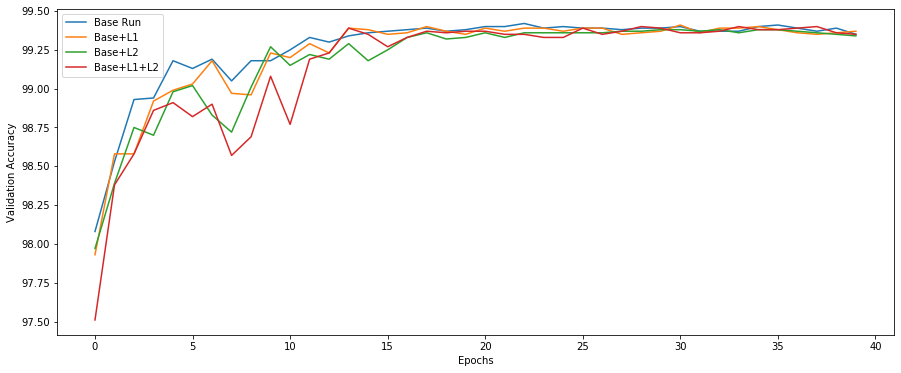

In [32]:
plot_graphs([Baseline_Model_Metrics['Test Accuracy'], Baseline_l1_Model_Metrics['Test Accuracy'], Baseline_l2_Model_Metrics['Test Accuracy'], Baseline_l1l2_Model_Metrics['Test Accuracy'] ],
            ['Base Run', 'Base+L1', 'Base+L2', 'Base+L1+L2'],
            xlabel="Epochs",
            ylabel="Validation Accuracy")

# Test Loss for all models

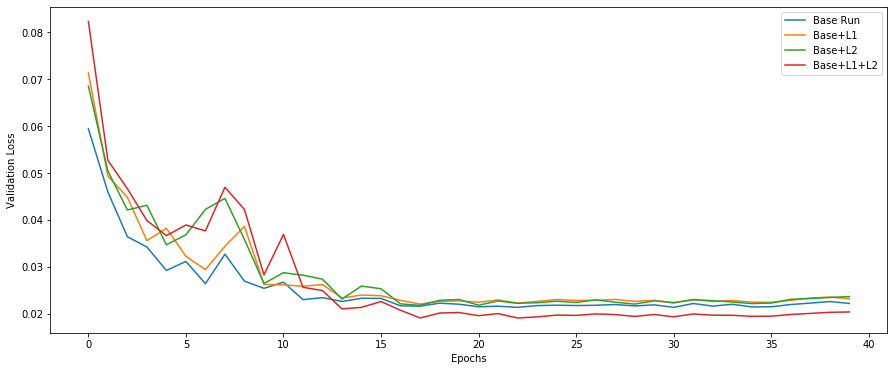

In [34]:
plot_graphs([Baseline_Model_Metrics['Test Loss'], Baseline_l1_Model_Metrics['Test Loss'], Baseline_l2_Model_Metrics['Test Loss'], Baseline_l1l2_Model_Metrics['Test Loss'] ],
            ['Base Run', 'Base+L1', 'Base+L2', 'Base+L1+L2'],
            xlabel="Epochs",
            ylabel="Validation Loss")

# Train Accuracy for all models

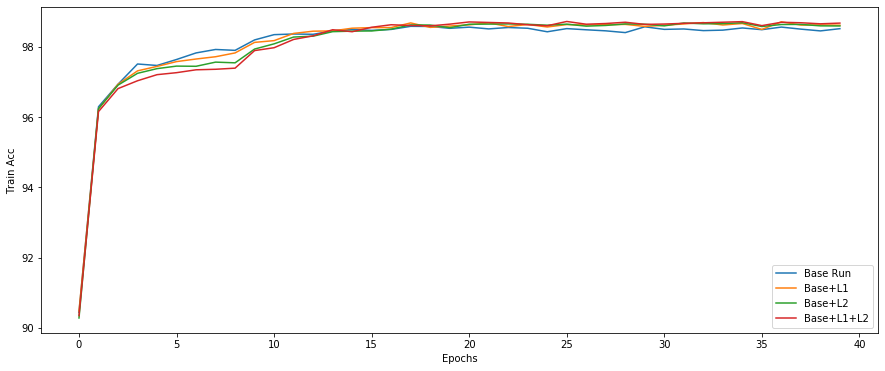

In [35]:
plot_graphs([Baseline_Model_Metrics['Train Accuracy'], Baseline_l1_Model_Metrics['Train Accuracy'], Baseline_l2_Model_Metrics['Train Accuracy'], Baseline_l1l2_Model_Metrics['Train Accuracy'] ],
            ['Base Run', 'Base+L1', 'Base+L2', 'Base+L1+L2'],
            xlabel="Epochs",
            ylabel="Train Acc")

# Train Loss for all Models

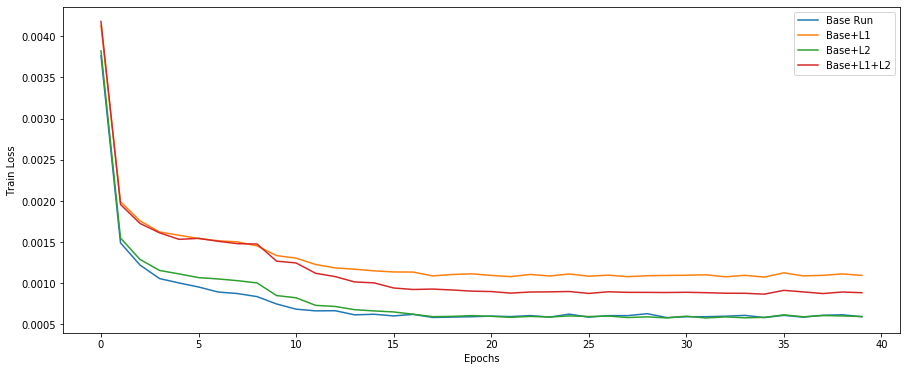

In [36]:
plot_graphs([Baseline_Model_Metrics['Train Loss'], Baseline_l1_Model_Metrics['Train Loss'], Baseline_l2_Model_Metrics['Train Loss'], Baseline_l1l2_Model_Metrics['Train Loss'] ],
            ['Base Run', 'Base+L1', 'Base+L2', 'Base+L1+L2'],
            xlabel="Epochs",
            ylabel="Train Loss")

# Misclassified images

In [0]:
def plot_misclassified(args, model, device, test_loader,epoch_number):
    model.eval()
    test_loss = 0
    correct = 0
    preds = np.array([])
    actuals = np.array([])
    error_images = []
    total_misclassified = 0
    total_rounds = 0
    with torch.no_grad():
        for data, target in test_loader:
            #print(len(data))
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            orig_labels = target.cpu().numpy()
            pred_labels = pred.squeeze().cpu().numpy()
            mislabeled_index = np.where(orig_labels != pred_labels)[0]
            total_rounds+=1
            if (mislabeled_index.shape[0] > 0):
                for iCount in range(len(mislabeled_index)):            
                    offset = mislabeled_index[iCount]
                    error_images.append(data[offset].cpu().numpy().squeeze())
                    preds=np.append(preds, pred_labels[offset])
                    actuals = np.append(actuals, orig_labels[offset])
                    total_misclassified += 1
    test_loss /= len(test_loader.dataset)
    test_accuracy = (100. * correct) / len(test_loader.dataset)
    print((total_misclassified))
    print(preds.shape)

    fig = plt.figure(figsize=(10,10))
    for idx in np.arange(25):
        ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
        plt.imshow(error_images[idx], cmap='gray_r')
        ax.set(ylabel="Pred="+str(np.int(preds[idx])), xlabel="Actual="+str(np.int(actuals[idx])))

    return test_accuracy, test_loss, None

In [38]:
kwargs_2 = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_loader_2 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=train_transforms),
    batch_size=config['batch_size'], shuffle=True, **kwargs_2)
test_loader_2 = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=test_transforms),
        batch_size=config['batch_size'], shuffle=False, **kwargs_2)

len(train_loader_2),len(test_loader_2)

(732, 122)

In [0]:
BASE_MODEL="/content/EVA4/model-baseline.h5"
L2_MODEL="/content/EVA4/model-baseline_l2.h5"
L1_MODEL="/content/EVA4/model-baseline_l1.h5"
L1L2_MODEL="/content/EVA4/model-baseline_l1l2.h5"

# Misclassified images with L1 & L2 Model 

In [0]:
my_model = model_builder(MNISTDigitBuilder, 
                      weights_path=L1L2_MODEL,
                      local_device=device)

65
(65,)
99.35 0.022184726095199586


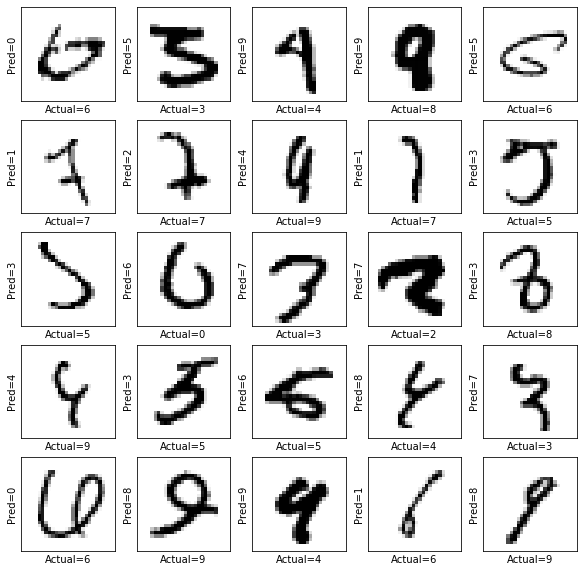

In [41]:
type(my_model)
epoch_test_acc,epoch_test_loss,preds = plot_misclassified(config, my_model, device, test_loader_2,1)
print(epoch_test_acc,epoch_test_loss)
#print(preds)

# Misclassified images with L1 Model 

In [0]:
my_model = model_builder(MNISTDigitBuilder, 
                      weights_path=L1_MODEL,
                      local_device=device)


63
(63,)
99.37 0.02318731710910797


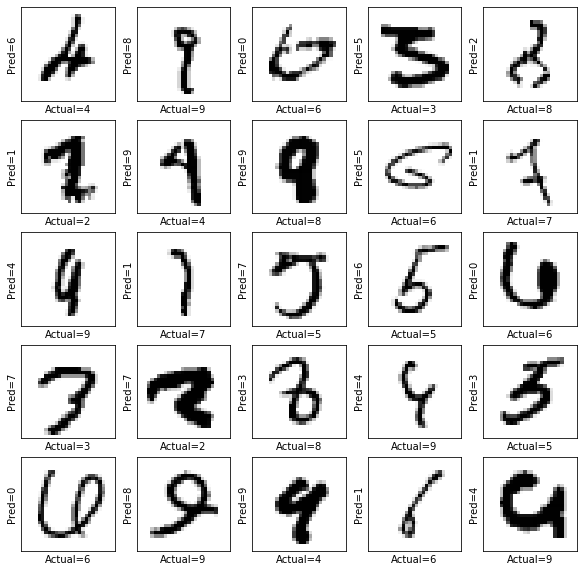

In [43]:
epoch_test_acc,epoch_test_loss,preds = plot_misclassified(config, my_model, device, test_loader_2,1)
print(epoch_test_acc,epoch_test_loss)
#print(preds)

# Misclassified images with L2 Model 

In [0]:
my_model = model_builder(MNISTDigitBuilder, 
                      weights_path=L2_MODEL,
                      local_device=device)

65
(65,)
99.35 0.020358983397483824


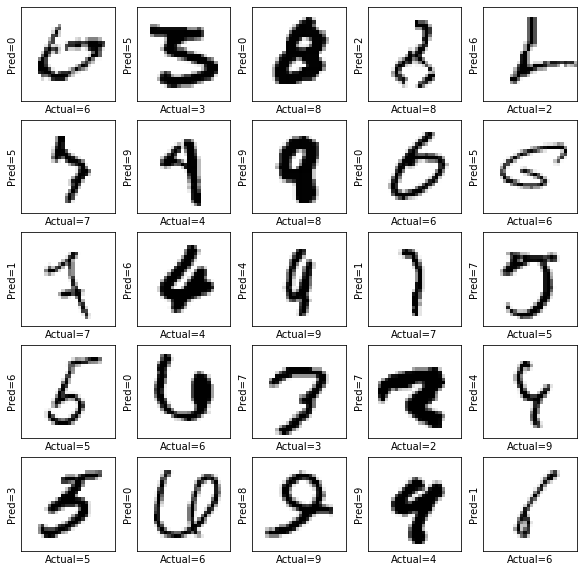

In [45]:
epoch_test_acc,epoch_test_loss,preds = plot_misclassified(config, my_model, device, test_loader_2,1)
print(epoch_test_acc,epoch_test_loss)
#print(preds)